# Implement RNN unfolding using RNNCell and LSTMCell

<br>
<font color='#2c3e50'>
    
- RNN, LSTM and GRU cells can be seen as neural networks that process each step of the input time-series (in somewhat recursive manner). This is often referred to as `unrolling or unfolding of RNN`.
- LSTM/RNN/GRU layers provide an abstraction over this operation.
</font>

## 1. Task:

<font color='red'>

<b>In this lab exercise, you have to implement `unfolding or unrolling` using `RNNCell` and `LSTMCell`. </b> 
</font>


<font color='#2c3e50'>  
<ul>    
<li>

RNNCell (or LSTMCell) takes a feature vector and hidden state (or hidden and cell state) at a time-step and outputs the updated hidden state (or hidden and cell states). The hidden state obtained after the last time-step is considered as a latent representation of the time-series and is given as input to the dense or classification layer(s). </li>   
    
<li>
    
This notebook contains two PyTorch model definitions (i.e. `LSTMClassifier` and `RNNClassifier`) and `trainer()` function to process the training data and train models. The entire code is in `almost` working condition. You need to complete the `forward()` function in both `LSTMClassifier` and `RNNClassifier` classes. In essence, you need to implement RNN unrolling in `forward()`. </li>   

    
<li>
    
If you are not comfortable with PyTorch, please see the Reference notebook. It summarises how to define and train a model in modular manner. </li>
    

<li> 
    
Since RNN cells are essentially composed of standard dense or linear layers, you are welcome to implement your own RNNCell instead of using the implemented one.  
    
    
</ul>
</font>
    
 
### 1.1 HINTS:
<br>
<font color='#2c3e50'>  
<ul>    
<li>
    
Run a loop over time-steps </li>

<li>
    
Neural network process one batch at a time. So, input to `RNNCell` at each time-step is `(batch_size,n_features)`</li>    
</ul>
</font>

### 1.2 Instructions:

- You have to implement `forward functions` in both `LSTMClassifier` and `RNNClassifier` classes. 
- These functions take a batch of time-series of size `(batch_size,n_steps,n_features)` and output mortality predictions (1/0 binary predictions) of shape `(batch_size,1)`.


### 1.3 Data:

- Physionet 2012: Mortality prediction (discussed yesterday)
- Each time-series consists of K-dimenional vector (`n_features=K`) at 48 time-steps (`n_steps=48`). `Size of each time-series : (48,K)`


## 2. Synatx of RNNCell and LSTMCell


### 2.1 RNNCell:


#### PyTorch syntax:
<img src="./img/rnn_cell_1.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/rnn_cell_2.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/rnn_cell_3.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/rnn_cell_4.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/rnn_cell_5.png" alt="Drawing" style="width: 800px;"/>

### 2.2 LSTMCell

#### PyTorch syntax:
<img src="./img/lstm_cell_1.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/lstm_cell_2.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/lstm_cell_3.png" alt="Drawing" style="width: 800px;"/>
<img src="./img/lstm_cell_4.png" alt="Drawing" style="width: 800px;"/>



### 2.3 More information at:

- http://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html
- http://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html

## Implementation Begins:

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score
from utils import get_validation_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
class RNNClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim,device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNNCell(input_dim, hidden_dim)  # RNN Cell
        self.fc = nn.Linear(hidden_dim, 1)            # fully connected layer: maps last hidden vector to model prediction
        self.activation = nn.Sigmoid()                # coz binary classification
        self.device=device
    
    def forward(self, x):

        hidden = self.init_hidden(x)
        
        ############################# 
        
        # Write you code here.
        # Return expects variable out. Its the hidden vector obtained after last time-step.
        
        time_steps=x.shape[1]                 # shape of x is (batches,time_Steps,features)
        
        for i in range(0,time_steps):
            inputs=x[:,i]                     # (batch,features) shape
            hidden = self.rnn(inputs,hidden)
            
        out = self.fc(hidden)                 # take the hidden vector corresponding to last time step
        ###########################
        
        return self.activation(out)
    
    def init_hidden(self, x):
        h0 = torch.zeros(x.size(0), self.hidden_dim)
        return h0.to(self.device)

In [3]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim,device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTMCell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        self.device=device
    
    def forward(self, x):
        hidden,cell = self.init_hidden(x)
        
        ############################
        
        # Write you code here.
        # Resturn expects variable out. Its the hidden vector obtained after last time-step.
        
        
        time_steps=x.shape[1]              #shape of x is (batches,time_Steps,features)
        
        for i in range(0,time_steps):
            inputs=x[:,i]                  # (batch,features) shape
            hidden,cell = self.rnn(inputs,(hidden,cell))
        
        out = self.fc(hidden)              # take the hidden vector corresponding to last time step
        #############################
        
        return self.activation(out)
    
    def init_hidden(self, x):
        h0 = torch.zeros(x.size(0), self.hidden_dim)
        c0 = torch.zeros(x.size(0), self.hidden_dim)
        return h0.to(self.device),c0.to(self.device)

In [4]:
# Function to compute validation score: Used in trainer()

def get_validation_score(model,Val_T,Val_L):
    model.eval()
    tensor_x = torch.Tensor(Val_T).to(model.device)
    preds=model(tensor_x)[:,0]
    LOSS=nn.BCELoss().to(device)
    val_loss=LOSS(preds,torch.Tensor(Val_L).type(torch.FloatTensor).to(model.device))
    return roc_auc_score(Val_L, preds.cpu().detach().numpy()), val_loss

In [5]:
def trainer(model,training_set,validation_set,device,lr,stored_name,epochs=10):
    
    # Recieves data and labels 
    T,L=training_set 
    Val_T,Val_L=validation_set
    
    # intialise optimiser and criterion
    
    optimizer_model = torch.optim.SGD(model.parameters(),lr,momentum=0.9, nesterov=True)
    criterion = nn.BCELoss().to(device)

    # 
    best=0
    LOSS=[]
    VAL_LOSS=[]
    
    # training begins
    
    for epoch in range(0,epochs):
        Loss=0
        model.train()
        for k in range(0,len(T)):
            
            inputs=T[k]
            labels=L[k]
            
            inputs=torch.Tensor(inputs).to(device)
            labels=torch.Tensor(labels).type(torch.FloatTensor).to(device)
            
            pred=model(inputs)
            
            loss=criterion(pred[:,0],labels)
            optimizer_model.zero_grad()
            loss.backward()
            optimizer_model.step()
            Loss=Loss+loss
           
        Val_ROC,val_loss=get_validation_score(model,Val_T,Val_L)
        VAL_LOSS.append(val_loss.detach().cpu().numpy())
        LOSS.append((Loss/len(T)).detach().cpu().numpy())
        
        print(' Epoch: {:.1f} Training Loss {:5f} Validation Loss {:.4f} Validation AUC {:.5f}'.format(epoch,LOSS[-1],VAL_LOSS[-1],Val_ROC))
        
        # If current validation score is greater than best, store the model
        
        if best<Val_ROC:
           torch.save(model, './'+stored_name) 

    return torch.load('./'+stored_name).to(device),LOSS,VAL_LOSS     

In [6]:
# Get training and validation data

from get_data import get_training_data,get_validation_data

T,L=get_training_data(batch_size=32)  # returns lists of training data and label batches
Val_T,Val_L=get_validation_data()     # numpy arrays of validation data and labels

print(T[0].shape)                     # (batch_size,time_steps,n_features)

(33, 48, 59)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
n_features=T[0].shape[2]     # 76 dimensional vector at each time step
recurrent_units=128          # number of hidden units in  a RNN/LSTM
lr=0.001                     # learning rate 

In [9]:
# Create LSTMClassifier model object

model=LSTMClassifier(n_features,recurrent_units,device)
print(model)

LSTMClassifier(
  (rnn): LSTMCell(59, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [10]:
# Train LSTMClassifier

model=model.to(device)
model, training_loss, validation_loss=trainer(model,(T,L),(Val_T,Val_L),device,lr,stored_name='lstm',epochs=10)

 Epoch: 0.0 Training Loss 0.557765 Validation Loss 0.4724 Validation AUC 0.66292
 Epoch: 1.0 Training Loss 0.448890 Validation Loss 0.4408 Validation AUC 0.71244
 Epoch: 2.0 Training Loss 0.431052 Validation Loss 0.4301 Validation AUC 0.74600
 Epoch: 3.0 Training Loss 0.419855 Validation Loss 0.4194 Validation AUC 0.76830
 Epoch: 4.0 Training Loss 0.408042 Validation Loss 0.4079 Validation AUC 0.78226
 Epoch: 5.0 Training Loss 0.395625 Validation Loss 0.3963 Validation AUC 0.79053
 Epoch: 6.0 Training Loss 0.383454 Validation Loss 0.3856 Validation AUC 0.79572
 Epoch: 7.0 Training Loss 0.372733 Validation Loss 0.3771 Validation AUC 0.79934
 Epoch: 8.0 Training Loss 0.364477 Validation Loss 0.3714 Validation AUC 0.80212
 Epoch: 9.0 Training Loss 0.358903 Validation Loss 0.3682 Validation AUC 0.80444


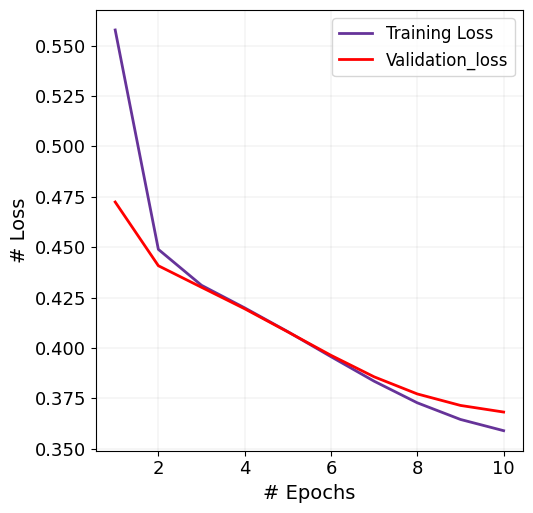

In [11]:
# Plot training and validation loss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

lw = 2

plt.tight_layout()
ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),training_loss, color='rebeccapurple',
         lw=2, linestyle='-', label='Training Loss')

ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),validation_loss, color='r',
         lw=2, linestyle='-', label='Validation_loss')

ax.set_xlabel('# Epochs',fontsize=14)
ax.set_ylabel('# Loss',fontsize=14)
ax.legend(loc="best",fontsize=12)

ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)


plt.grid(color='gray', linestyle='-', linewidth=0.1)


plt.show()

In [12]:
# Create RNNClassifier model object

model=RNNClassifier(n_features,recurrent_units,device)
print(model)


RNNClassifier(
  (rnn): RNNCell(59, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [13]:
# Train RNNClassifier

model=model.to(device)
model, training_loss, validation_loss=trainer(model,(T,L),(Val_T,Val_L),device,lr,stored_name='rnn',epochs=10)

 Epoch: 0.0 Training Loss 0.461752 Validation Loss 0.4137 Validation AUC 0.76795
 Epoch: 1.0 Training Loss 0.377099 Validation Loss 0.3698 Validation AUC 0.80352
 Epoch: 2.0 Training Loss 0.353274 Validation Loss 0.3676 Validation AUC 0.80792
 Epoch: 3.0 Training Loss 0.350327 Validation Loss 0.3660 Validation AUC 0.81007
 Epoch: 4.0 Training Loss 0.348616 Validation Loss 0.3649 Validation AUC 0.81140
 Epoch: 5.0 Training Loss 0.347329 Validation Loss 0.3641 Validation AUC 0.81251
 Epoch: 6.0 Training Loss 0.346274 Validation Loss 0.3635 Validation AUC 0.81337
 Epoch: 7.0 Training Loss 0.345370 Validation Loss 0.3629 Validation AUC 0.81418
 Epoch: 8.0 Training Loss 0.344571 Validation Loss 0.3624 Validation AUC 0.81498
 Epoch: 9.0 Training Loss 0.343848 Validation Loss 0.3620 Validation AUC 0.81571


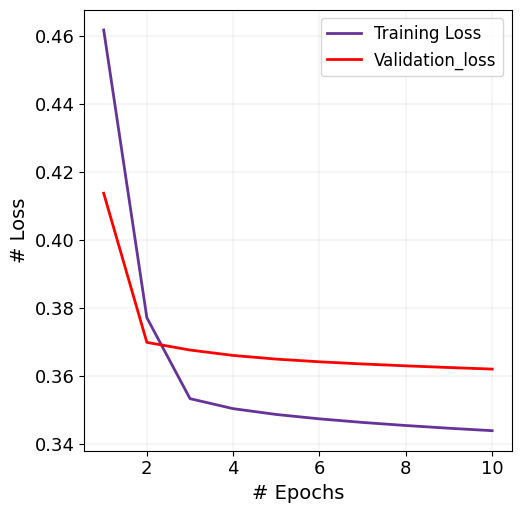

In [14]:
# Plot training and validation loss

fig, ax = plt.subplots(figsize=(5,5))

lw = 2

plt.tight_layout()
ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),training_loss, color='rebeccapurple',
         lw=2, linestyle='-', label='Training Loss')

ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),validation_loss, color='r',
         lw=2, linestyle='-', label='Validation_loss')

ax.set_xlabel('# Epochs',fontsize=14)
ax.set_ylabel('# Loss',fontsize=14)
ax.legend(loc="best",fontsize=12)

ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)


plt.grid(color='gray', linestyle='-', linewidth=0.1)


#plt.savefig('./loss_curves.pdf',dpi=100,bbox_inches='tight')
plt.show()